In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
# NOTE: for some reason mps is much slower than cpu. commented off for now

# if torch.backends.mps.is_built() and torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")

device = torch.device("cpu")

In [4]:
with open("names.txt", "r") as f:
    names = [_.strip() for _ in f.readlines()]

names[0:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
len(names)

32033

In [6]:
chars = list(set("".join(names)))
chars.sort()
chars.insert(0, ".")

chars[0:5]

['.', 'a', 'b', 'c', 'd']

In [7]:
ctoi = {c:i for i, c in enumerate(chars)}
itoc = {i:c for i, c in enumerate(chars)}

ctoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [8]:
ctx_size=3

def create_ds(names):
    X = [] # (m, 3)
    Y = [] # (m)

    for s in names:
        s = s + "."
        ctx = [0] * ctx_size
        for c in s:
            ix = ctoi[c]
            X.append(ctx)
            Y.append(ix)
            ctx = list(ctx[1:])
            ctx.append(ix)

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

X, Y = create_ds(names)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [9]:
X[0:5]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [10]:
names[0]

'emma'

In [11]:
[ctoi[c] for c in names[0]]

[5, 13, 13, 1]

In [12]:
[train, dev, test] = random_split(names, [0.8, 0.1, 0.1])
x_train, y_train = create_ds(train)
x_dev, y_dev = create_ds(dev)
x_test, y_test = create_ds(test)

In [185]:
g = torch.Generator().manual_seed(2147483647)

def init_params(emb_size=10, hidden_size=100):
    C  = torch.randn((27, emb_size),                      generator=g)
    W1 = torch.randn((emb_size * ctx_size, hidden_size),  generator=g) * (5/3) / (emb_size * ctx_size)**0.5
    W2 = torch.randn((hidden_size, 27),                   generator=g) * 0.01
    b2 = torch.randn((27),                                generator=g) * 0
    
    bn_gain = torch.ones(1, hidden_size)
    bn_bias = torch.zeros(1, hidden_size)
    bn_mean = torch.zeros(1, hidden_size)
    bn_std = torch.ones(1, hidden_size)
    
    params = [C, W1, W2, b2, bn_gain, bn_bias]
    for p in params:
        p.requires_grad = True
    
    return params, [bn_mean, bn_std]

params = init_params()
sum([_.nelement() for _ in params[0]])

6197

In [175]:
def forward(x, y, params, test=False):
    C, W1, W2, b2, bn_gain, bn_bias = params[0]
    bn_mean, bn_std = params[1]
    ctx_size = x.shape[1]
    emb_size = C.shape[1]
    
    emb = C[x].view(-1, emb_size * ctx_size)
    
    pre = emb @ W1   
    # batch norm
    mean = pre.mean(0, keepdim=True)
    std = pre.std(0, keepdim=True)
    pre = (pre - mean) / std
    pre = bn_gain * pre + bn_bias
    
    with torch.no_grad():
        bn_mean.data = 0.999 * bn_mean + 0.001 * mean
        bn_std.data = 0.999 * bn_std + 0.001 * std
    
    h = pre.tanh()
    
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    return loss

In [176]:
batch_size = 32

def fit(params, lr, epoch):
    history = []
    
    for t in range(epoch):
        ix = torch.randint(0, x_train.shape[0], (batch_size,), device=device)
        x = x_train[ix]
        y = y_train[ix]

        for p in params[0]:
            p.grad = None

        loss = forward(x, y, params)
        loss.backward()
        history.append(loss.item())

        for p in params[0]:
            p.data -= lr * p.grad
        
        if t > 10000:
            lr = 0.01
    
    return history

In [179]:
params = init_params()
history = fit(params, 0.1, 60000)
history[-1]

2.054093360900879

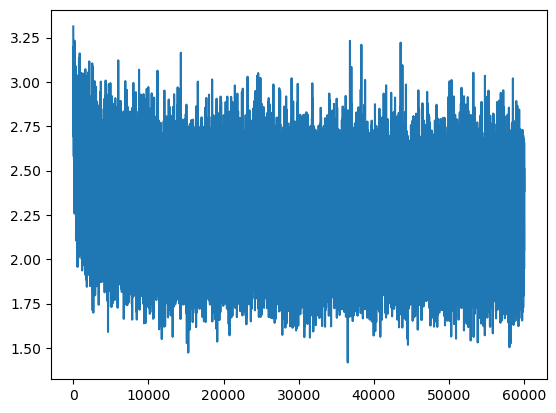

In [172]:
plt.plot(history);

In [72]:
def try_ls(lr):
    params = init_params(emb_size=10, hidden_size=100)
    _, loss_d = fit(params, lr, 10000, loss_train=False, loss_dev=True)
    return loss_d

In [ ]:
lrs = torch.linspace(-8, 0, steps=100).exp()
len(lrs)

In [ ]:
loss = [try_ls(lr) for lr in tqdm(lrs)]

In [76]:
min(zip(lrs, loss), key=lambda k:k[1])

(tensor(0.1128), 2.3968825340270996)

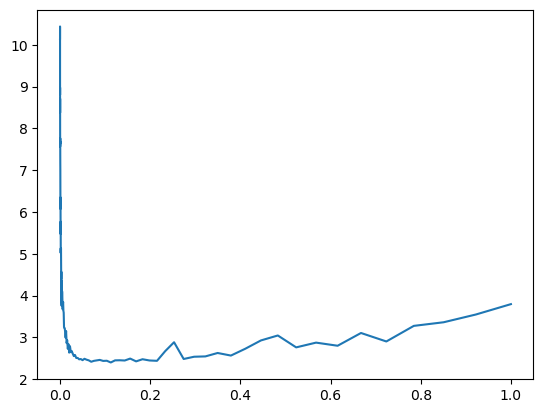

In [75]:
plt.plot(lrs, loss)

Further narrow down the choice

In [80]:
lrs = torch.linspace(-5, -1.5, steps=100).exp()
len(lrs)

100

In [97]:
loss = [try_ls(lr) for lr in tqdm(lrs)]
min(zip(lrs, loss), key=lambda k:k[1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


(tensor(0.0720), 2.3719685077667236)

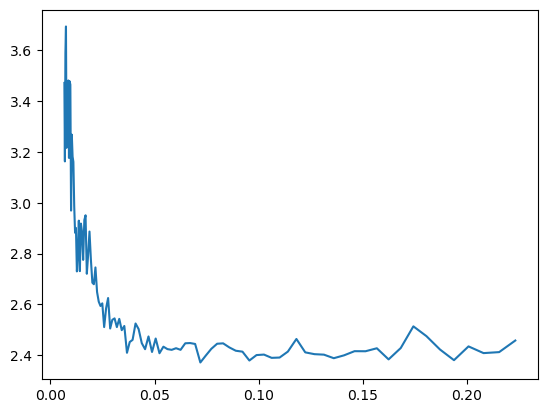

In [99]:
plt.plot(lrs, loss)

In [ ]:
emb_sizes = range(2, 30, 1)
hidden_sizes = range(50, 200, 5)

def try_param(embed_size, hidden_size):
    params = init_params(embed_size, hidden_size)
    loss_t, loss_d = fit(params, 0.07, 10000)
    return loss_t, loss_d

result = []
param_set = [(e, h) for e in emb_sizes for h in hidden_sizes]

for (e, h) in tqdm(param_set):
    loss_t, loss_d = try_param(e, h)
    result.append([e, h, loss_t, loss_d])

In [ ]:
min(result, key = lambda k: k[3])

In [ ]:
xs = [_[0] for _ in result]
ys = [_[1] for _ in result]
zs = [_[3] for _ in result]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('embed')
ax.set_ylabel('hidden')
ax.set_zlabel('dev loss')

In [180]:
def eval_dataset(params, x, y):
    with torch.no_grad():
        C, W1, W2, b2, bn_gain, bn_bias = params[0]
        bn_mean, bn_std = params[1]
        ctx_size = x.shape[1]
        emb_size = C.shape[1]

        emb = C[x].view(-1, emb_size * ctx_size)

        pre = emb @ W1 + b1    
        # batch norm
        pre = (pre - bn_mean) / bn_std
        pre = bn_gain * pre + bn_bias
        h = pre.tanh()

        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y).item()
        return loss

In [165]:
eval_dataset(params, x_dev, y_dev)

2.2184877395629883

In [182]:
def sample():
    C, W1, W2, b2, bn_gain, bn_bias = params[0]
    bn_mean, bn_std = params[1]
    ctx_size = 3
    emb_size = C.shape[1]
    sampl = [0] * ctx_size
    
    with torch.no_grad():
        for _ in range(1000):
            x = torch.tensor([sampl[-3:]])
            emb = C[x].view(-1, emb_size * ctx_size)

            pre = emb @ W1   
            # batch norm
            pre = (pre - bn_mean) / bn_std
            pre = bn_gain * pre + bn_bias
            h = pre.tanh()
            
            logits = h @ W2 + b2
            prob = F.softmax(logits, dim=1)
            prob = prob[0]
            ix = torch.multinomial(prob, 1).item()
            sampl.append(ix)

            if ix == 0:
                break;

    return "".join([itoc[ix] for ix in sampl[3:-1]])

for _ in range(20):
    print(sample())

haden
khusa
deh
tora
pance
dengaloustian
shin
avoni
elloykearsi
jammaary
jama
fvio
lakeniyah
mirah
gran
turtevyaunytengr
male
aaryustear
owen
kammy
